In [1]:
import sys, os, copy, time
sys.path.append('/home/achint/Generative_Modelling/Ziyi_1/POISEVAE-main')

import random
import numpy as np
import torch
HOME_PATH = os.path.expanduser('~')

import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import poisevae
from poisevae.datasets import MNIST
from poisevae.networks.PixelCNN_MNIST import EncMNIST, DecMNIST
from poisevae.networks.pixelcnn import PixelCNN

In [2]:
MNIST_PATH = "/home/achint/datasets/MNIST/%s.pt"

joint_dataset_train = MNIST(mnist_pt_path=MNIST_PATH % 'training')
joint_dataset_test = MNIST(mnist_pt_path=MNIST_PATH % 'test')

In [3]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)
len(train_loader), len(test_loader)

(468, 78)

In [4]:
lat1, lat2 = 20, 20
color_level = 256
device = 'cpu' #'cuda' if torch.cuda.is_available() else 'cpu'

enc_mnist1 = EncMNIST(lat1).to(device)
dec_mnist1 = DecMNIST(PixelCNN(lat1, 1, color_level), color_level).to(device)
enc_mnist2 = EncMNIST(lat1).to(device)
dec_mnist2 = DecMNIST(PixelCNN(lat2, 1, color_level), color_level).to(device)

# Options: 'derivative_autograd', 'derivative_gradient', and 'std_normal'
vae = poisevae.POISEVAE([enc_mnist1, enc_mnist2], [dec_mnist1, dec_mnist2], latent_dims=[lat1, (lat2)], 
                        enc_config='nu', KL_calc='std_normal', batch_size=batch_size
                       ).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
writer = None

In [5]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), data[0].to(device, dtype=torch.float32)], dec_kwargs={'generate_mode':False})#, 
                      # n_gibbs_iter=30)
        break

In [6]:
results

{'z': [tensor([[-0.5507,  0.2364, -0.3138,  ...,  1.8961, -0.2298, -0.2071],
          [ 0.0252, -0.2279, -0.0392,  ..., -0.6285, -0.9743,  1.2018],
          [-0.4272, -0.3770, -0.5400,  ..., -0.2467,  0.6530,  0.8201],
          ...,
          [ 0.1288, -0.6170,  0.4015,  ...,  1.6168,  0.0552, -0.5960],
          [-0.0263,  0.4923,  0.0367,  ...,  0.3313,  0.4633,  0.4983],
          [-0.3304,  0.0711, -0.1354,  ...,  0.2236,  0.1320,  0.3311]]),
  tensor([[ 0.8443,  0.5284,  0.7881,  ...,  1.3131,  0.1831, -0.3689],
          [ 0.1767,  0.5270,  0.6154,  ..., -0.9377, -0.3087, -0.6056],
          [-1.4400, -0.9666, -0.3797,  ..., -0.2315,  0.4164,  0.2637],
          ...,
          [ 0.4738, -0.6907,  0.3470,  ...,  0.6932,  0.4618, -0.2996],
          [ 0.0032, -0.7835,  0.3877,  ...,  0.6041,  0.7722, -0.1634],
          [-0.7651,  0.0247, -0.3850,  ..., -0.2006,  0.2235, -0.0700]])],
 'x_rec': [tensor([[[[0.3198, 0.3177, 0.3251,  ..., 0.3261, 0.3261, 0.3261],
            [0.3137

In [27]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
#     x_rec = [x_rec[0].probs, x_rec[1].probs]
#     idx = torch.where(results['weights'] == results['weights'].max(dim=1).values[:, None])
#     x_rec = [x_rec[0].loc[idx], x_rec[1].loc[idx]] # (batch, IW samples, ...)
    x_rec = [x_rec[0].loc[idx], x_rec[1].loc[idx]] # (batch, IW samples, ...)

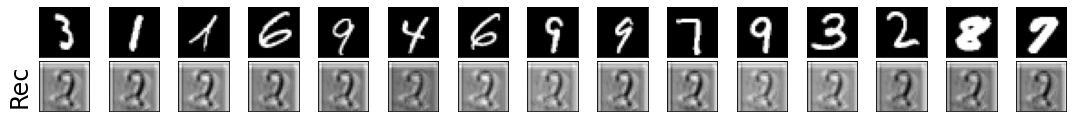

In [28]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0][25:,:], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

In [29]:
x_rec[0].size()

torch.Size([15, 1, 28, 28])

In [30]:
data[0].size()

torch.Size([128, 784])